In [ ]:
# Cell 1: Import libraries & mount Google Drive
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from tqdm import tqdm

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models

# Jika di Google Colab, mount drive
from google.colab import drive
drive.mount('/content/drive')

# Optional: cek versi (debugging)
print("numpy:", np.__version__)
print("opencv:", cv2.__version__)
print("tensorflow:", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
numpy: 2.0.2
opencv: 4.12.0
tensorflow: 2.19.0


In [ ]:
# Cell 2: Jika dataset berupa zip di Drive, unzip (sesuaikan path file zip di Drive)


# Tentukan lokasi folder images (sesuaikan dengan Drive-mu)
train_dir = "/content/drive/MyDrive/dataset/images/training"  # pastikan berisi folder 'day' dan 'night'
test_dir  = "/content/drive/MyDrive/dataset/images/test"      # pastikan berisi folder 'day' dan 'night'
print("Train dir:", train_dir)
print("Test dir:", test_dir)


Train dir: /content/drive/MyDrive/dataset/images/training
Test dir: /content/drive/MyDrive/dataset/images/test


Jumlah data training: 240
Jumlah data testing:  160


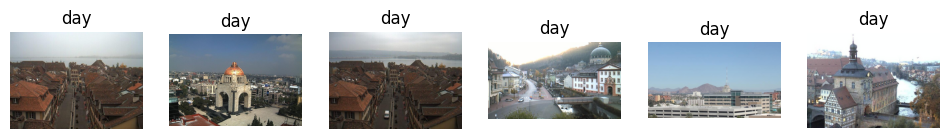

In [ ]:
# Cell 3: fungsi untuk load dataset
from pathlib import Path

def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    if not p.exists():
        raise FileNotFoundError(f"Path tidak ada: {img_dir}")
    for folder in sorted(p.glob('*')):
        if not folder.is_dir():
            continue
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            if img is None:
                # skip bila gagal baca
                print("Warning: gagal membaca", file)
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

# Load
train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing:  {len(test_img)}")

# Tampilkan contoh
def show_examples(img_list, n=6):
    plt.figure(figsize=(12,6))
    for i, (img, label) in enumerate(img_list[:n]):
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_examples(train_img, n=6)


In [ ]:
# Cell 4: resize & label encoder
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def label_encoder(label):
    # toleransi huruf Kapital/Spasi
    lbl = label.strip().lower()
    if lbl == 'day':
        return 1
    elif lbl == 'night':
        return 0
    else:
        raise ValueError(f"Label tidak dikenal: {label}")

def preprocess(img_list, size=(256,256)):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img, size)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img, size=(256,256))
X_test_img,  y_test  = preprocess(test_img, size=(256,256))

print("Contoh ukuran gambar:", X_train_img[0].shape)
print("Jumlah train img:", len(X_train_img))
print("Jumlah test img :", len(X_test_img))


Contoh ukuran gambar: (256, 256, 3)
Jumlah train img: 240
Jumlah test img : 160


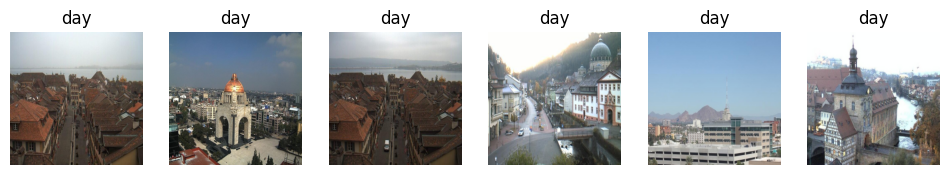

In [ ]:
# Cell 5
show_examples(list(zip(X_train_img, [ 'day' if x==1 else 'night' for x in y_train ])), n=6)


In [ ]:
# Cell 6: ekstraksi HOG (akan memakan waktu tergantung jumlah gambar)
from skimage.feature import hog

def extract_hog(X_imgs, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9):
    feats = []
    for img in tqdm(X_imgs, desc="Extract HOG"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

print("Feature shape train:", X_train_feat.shape)
print("Feature shape test :", X_test_feat.shape)


Extract HOG: 100%|██████████| 160/160 [00:04<00:00, 32.05it/s]

Feature shape train: (240, 34596)
Feature shape test : (160, 34596)


In [ ]:
# Cell 7: normalize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


Scaled shapes: (240, 34596) (160, 34596)


In [ ]:
# Cell 8: split train -> train + val
X_train, X_val, y_train_arr, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # jaga proporsi kelas
)

# convert to numpy arrays
y_train_arr = np.array(y_train_arr)
y_val = np.array(y_val)
y_test_arr = np.array(y_test)

print("Shapes:", X_train.shape, X_val.shape, X_test_scaled.shape)
print("Label distribusi (train):", np.bincount(y_train_arr))
print("Label distribusi (val):", np.bincount(y_val))
print("Label distribusi (test):", np.bincount(y_test_arr))


Shapes: (192, 34596) (48, 34596) (160, 34596)
Label distribusi (train): [96 96]
Label distribusi (val): [24 24]
Label distribusi (test): [80 80]


In [ ]:
# Cell 9: build model
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 10: train model
history = model.fit(
    X_train, y_train_arr,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=2
)


Epoch 1/20
6/6 - 2s - 382ms/step - accuracy: 0.7188 - loss: 1.0921 - val_accuracy: 0.9583 - val_loss: 0.5325
Epoch 2/20
6/6 - 0s - 73ms/step - accuracy: 0.9583 - loss: 0.2925 - val_accuracy: 0.9583 - val_loss: 0.7264
Epoch 3/20
6/6 - 0s - 74ms/step - accuracy: 0.9740 - loss: 0.3783 - val_accuracy: 0.9583 - val_loss: 0.8490
Epoch 4/20
6/6 - 0s - 72ms/step - accuracy: 0.9740 - loss: 0.1676 - val_accuracy: 0.9583 - val_loss: 0.9061
Epoch 5/20
6/6 - 1s - 100ms/step - accuracy: 0.9844 - loss: 0.1081 - val_accuracy: 0.9583 - val_loss: 0.9267
Epoch 6/20
6/6 - 1s - 101ms/step - accuracy: 0.9844 - loss: 0.0857 - val_accuracy: 0.9583 - val_loss: 0.9169
Epoch 7/20
6/6 - 1s - 102ms/step - accuracy: 0.9948 - loss: 0.0127 - val_accuracy: 0.9583 - val_loss: 0.9232
Epoch 8/20
6/6 - 1s - 103ms/step - accuracy: 0.9948 - loss: 0.0349 - val_accuracy: 0.9583 - val_loss: 0.9504
Epoch 9/20
6/6 - 1s - 103ms/step - accuracy: 0.9948 - loss: 0.0256 - val_accuracy: 0.9583 - val_loss: 0.9760
Epoch 10/20
6/6 - 1s -

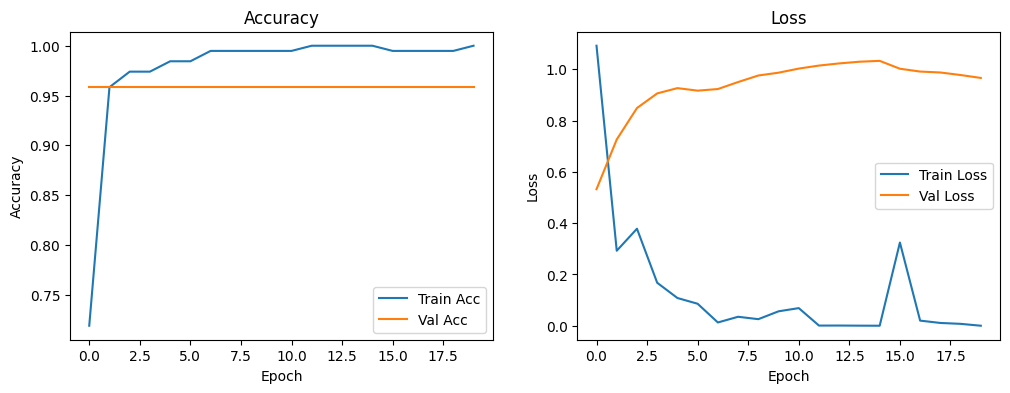

In [ ]:
# Cell 11: plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Loss')

plt.show()


Test Loss: 2.069706678390503
Test Accuracy: 0.8812500238418579
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Classification Report:
              precision    recall  f1-score   support

       night       0.87      0.90      0.88        80
         day       0.90      0.86      0.88        80

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160



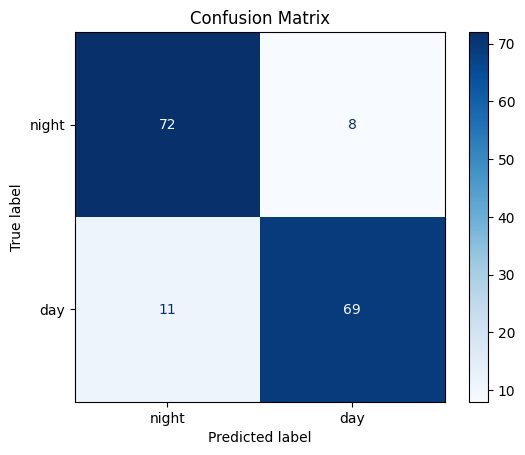

In [ ]:
# Cell 12: evaluate on test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_arr, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Prediksi
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred, target_names=['night','day']))

cm = confusion_matrix(y_test_arr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['night','day'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Cell 13: saving artifacts
save_dir = "/content/drive/MyDrive/day_night_artifacts"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "day_night_model.h5")
scaler_path = os.path.join(save_dir, "scaler.pkl")

# Save model
model.save(model_path)
print("✅ Model saved to:", model_path)

# Save scaler
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved to:", scaler_path)


✅ Model saved to: /content/drive/MyDrive/day_night_artifacts/day_night_model.h5
✅ Scaler saved to: /content/drive/MyDrive/day_night_artifacts/scaler.pkl


In [ ]:
import os

dir_path = '/content/daynight-classifier-2341720065'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Directory '{dir_path}' created successfully.")
else:
    print(f"Directory '{dir_path}' already exists.")

Directory '/content/daynight-classifier-2341720065' created successfully.


In [ ]:
%cd /content/daynight-classifier-2341720065

/content/daynight-classifier-2341720065


In [ ]:
%%writefile app.py
import os
import numpy as np
import cv2
import pickle
import tensorflow as tf
from flask import Flask, request, render_template_string
from skimage.feature import hog

app = Flask(__name__)

MODEL_PATH = 'day_night_model.h5'
SCALER_PATH = 'scaler.pkl'

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    with open(SCALER_PATH, 'rb') as f:
        scaler = pickle.load(f)
    print("✅ System Loaded Successfully")
except Exception as e:
    print(f"❌ Error loading system: {e}")

def preprocess_image(image_bytes):
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    return scaler.transform(hog_feat.reshape(1, -1))

@app.route('/', methods=['GET'])
def home():
    return render_template_string('''
    <div style="text-align:center; padding:50px;">
        <h1>Day vs Night Classifier</h1>
        <form action="/predict" method="post" enctype="multipart/form-data">
            <input type="file" name="file" required><br><br>
            <button type="submit">Prediksi</button>
        </form>
    </div>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        file = request.files['file']
        data = preprocess_image(file.read())
        prediction = model.predict(data)[0][0]

        label = "Day (Siang)" if prediction > 0.5 else "Night (Malam)"
        return f"<h2 style='text-align:center'>Hasil: {label}</h2><center><a href='/'>Kembali</a></center>"
    except Exception as e:
        return f"Error: {e}"

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=7860)

Writing app.py


In [ ]:
%%writefile requirements.txt
flask
tensorflow-cpu
numpy
scikit-learn
scikit-image
opencv-python-headless
gunicorn

Writing requirements.txt


In [ ]:
%%writefile Dockerfile
FROM python:3.9-slim

RUN apt-get update && apt-get install -y \
    libgl1 \
    libglib2.0-0 \
    && rm -rf /var/lib/apt/lists/*

RUN useradd -m -u 1000 user
USER user
ENV PATH="/home/user/.local/bin:$PATH"

WORKDIR /app

COPY --chown=user ./requirements.txt requirements.txt
RUN pip install --no-cache-dir --upgrade -r requirements.txt

COPY --chown=user . /app

EXPOSE 7860
CMD ["python", "app.py"]

Writing Dockerfile


In [ ]:
!cp /content/drive/MyDrive/day_night_artifacts/day_night_model.h5 .
!cp /content/drive/MyDrive/day_night_artifacts/scaler.pkl .

In [ ]:
!git clone https://huggingface.co/spaces/agenaputra/daynight-classifier-2341720065 agenaputra/daynight-classifier-2341720065

Cloning into 'agenaputra/daynight-classifier-2341720065'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (11/11), 3.22 KiB | 299.00 KiB/s, done.


In [ ]:
%cd /content/daynight-classifier-2341720065/agenaputra/daynight-classifier-2341720065


/content/daynight-classifier-2341720065/agenaputra/daynight-classifier-2341720065


In [ ]:
!cp /content/daynight-classifier-2341720065/app.py .
!cp /content/daynight-classifier-2341720065/requirements.txt .
!cp /content/daynight-classifier-2341720065/Dockerfile .
!cp /content/daynight-classifier-2341720065/day_night_model.h5 .
!cp /content/daynight-classifier-2341720065/scaler.pkl .


In [ ]:
!git config --global user.email "agenaputra@gmail.com"
!git config --global user.name "Agna Putra"


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
!git config --global credential.helper store


In [ ]:
!git add .
!git commit -m "Deploy aplikasi day night classifier"
!git push


[main 7d7ee50] Deploy aplikasi day night classifier
 4 files changed, 7 insertions(+), 10 deletions(-)
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 803 bytes | 803.00 KiB/s, done.
Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/spaces/agenaputra/daynight-classifier-2341720065
   b539f7c..7d7ee50  main -> main


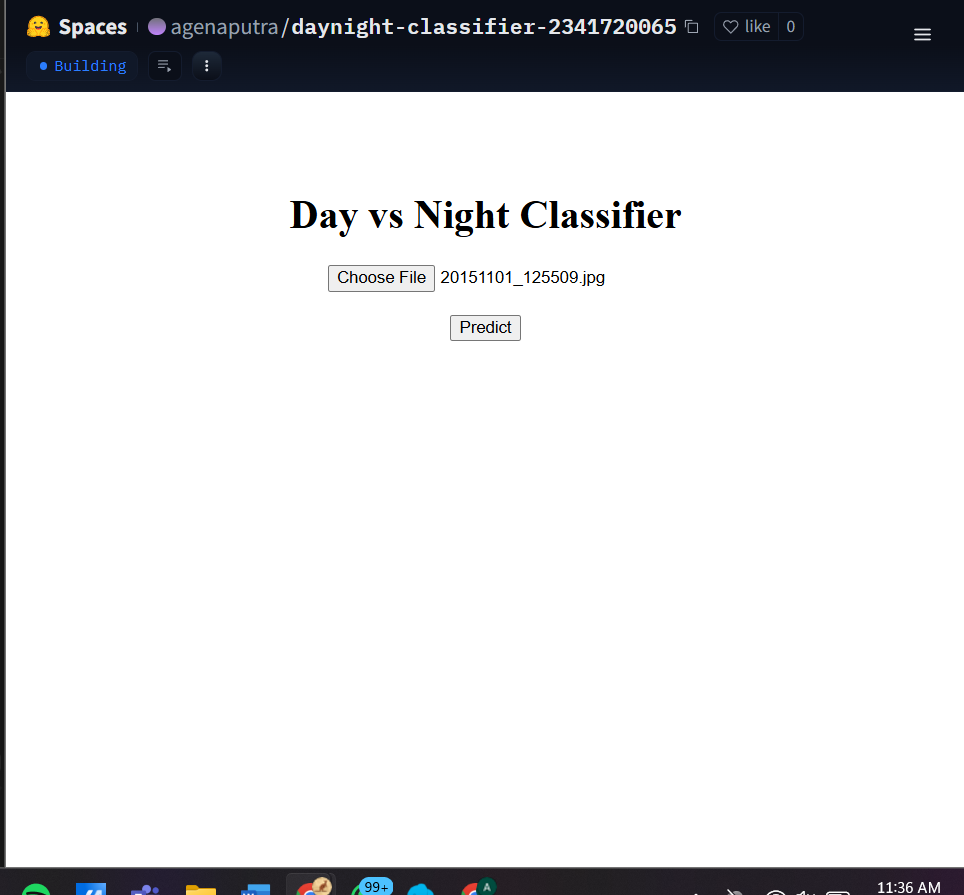

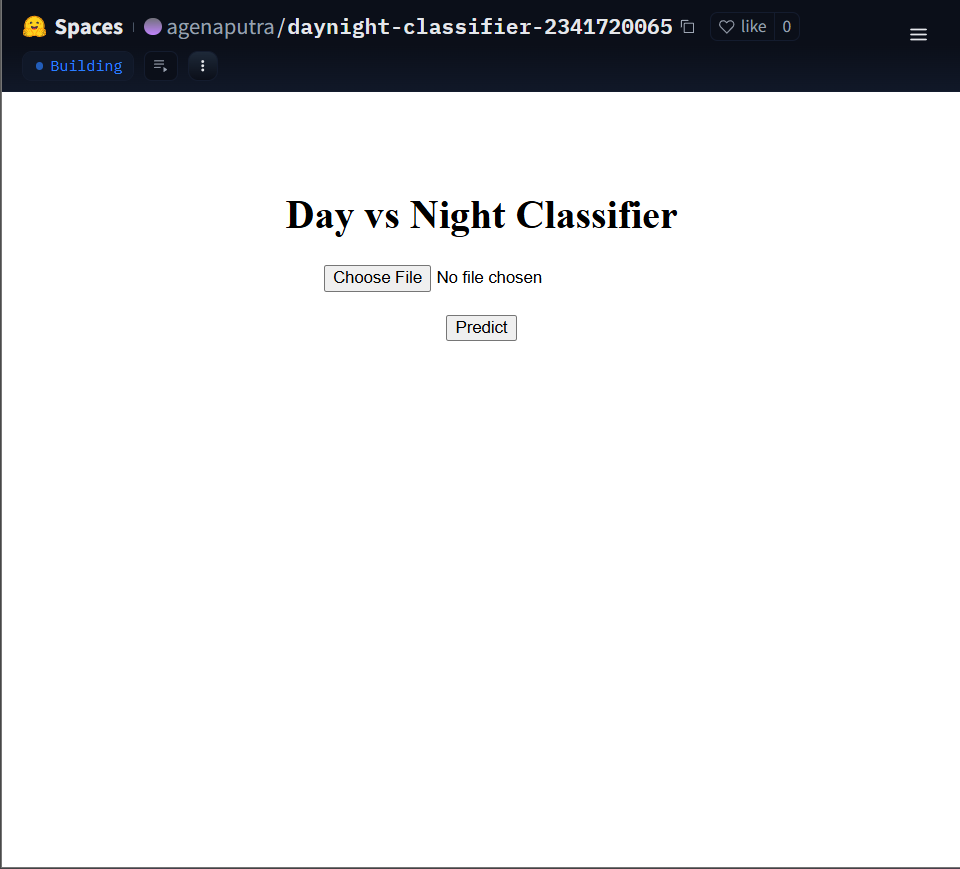

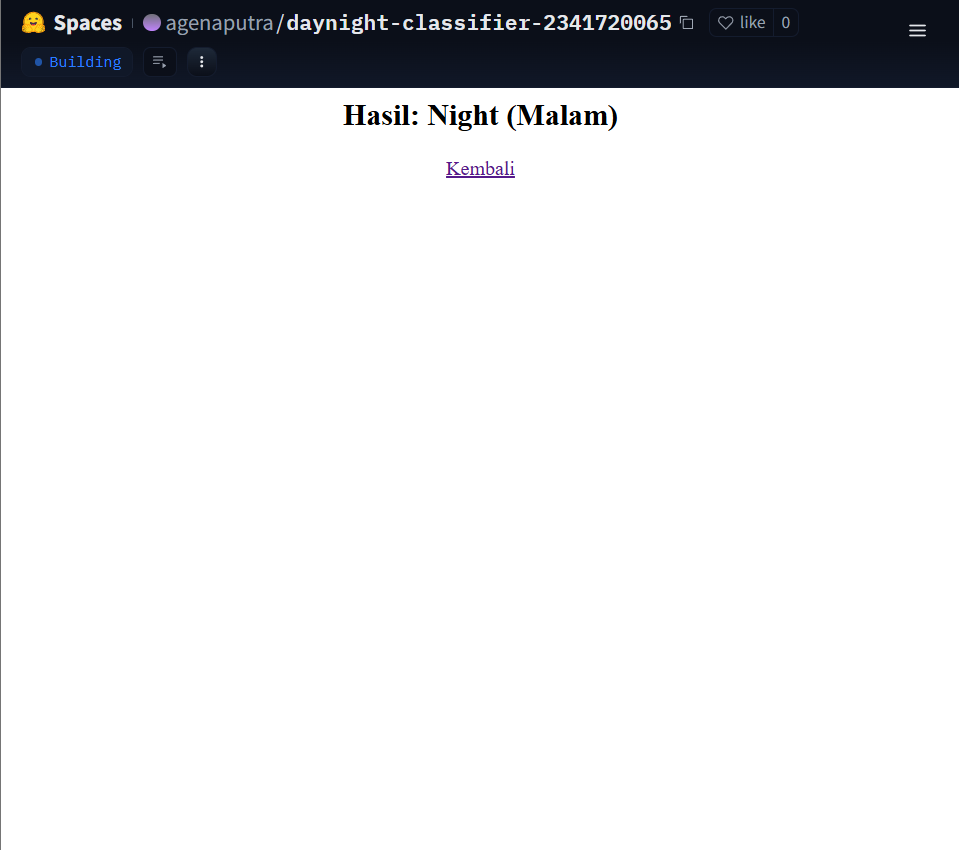